In [1]:
import torch
import pickle
import numpy as np
from evaluation import *
from functions import *
from Models.AutoEncoderEx import *
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading dataset
x = pickle.load(open("./Xs.pkl", "rb"))
y = pickle.load(open("./Ys.pkl", "rb"))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

In [4]:
# Shifting dimensions
x, y = x.permute(0, 3, 1, 2), y.permute(0, 3, 1, 2)
# Removing channel 1 in input channels
x = torch.cat((x[:, 0:1, :, :], x[:, 2:, :, :]), dim=1)
# Adding binary channel to describe the shape of object
bin_channel = torch.isnan(x[:, 2:, :, :]).type(torch.float)
x = bin_channel
print(torch.sum(bin_channel))

tensor(467592.)


In [5]:
# Removing NaN values
x[torch.isnan(x)] = 0
y[torch.isnan(y)] = 0

In [6]:
# Computing Root Mean Square of features to equally prioritize each feature in loss function
features_mse = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).view(-1, y.shape[1]) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
print(features_mse)

tensor([[[[0.1156]],

         [[0.0173]],

         [[0.0135]]]], device='cuda:0')


In [7]:
print(x.shape)
print(y.shape)

torch.Size([961, 1, 172, 79])
torch.Size([961, 3, 172, 79])


In [8]:
# Shuffling the dataset
x, y = shuffle_tensors(x, y)

In [9]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)
train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)

In [10]:
# Creating model
model = AutoEncoderEx(1, 3, filters=[8,16,32,32], kernel_size=7,
                    batch_norm=False, weight_norm=False)
model

AutoEncoderEx(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (1): Sequential(
        (0): ConvTranspose2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (2): Sequential(
        (0): ConvTranspose2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (3)

In [11]:
# Initializing weights
# initialize(model)

In [12]:
# Initializing optimizer
lr = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [13]:
# Defining loss function
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    loss = ((output - y) ** 2) / features_mse
    return torch.sum(loss), output

In [14]:
# Selecting sample from test dataset for visualization
sample_x, sample_y = test_data[0][0:1].to(device), test_data[1][0:1].to(device)

In [15]:
# Computing output and error for test sample
def compute_error(model, sample_x, sample_y):
    with torch.no_grad():
        out_y = model(sample_x)
        error = torch.abs(sample_y - out_y)
        return out_y, error

In [16]:
# Visualize sample
def visualize(sample_y, out_y, error):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    plt.subplot(3, 3, 1)
    plt.title('CFD', fontsize=18) 
    plt.imshow(np.transpose(sample_y[0,0,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Ux', fontsize=18)
    plt.subplot(3, 3, 2)
    plt.title('CNN', fontsize=18) 
    plt.imshow(np.transpose(out_y[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 3)
    plt.title('Error', fontsize=18)
    plt.imshow(np.transpose(error[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 4)
    plt.imshow(np.transpose(sample_y[0,1,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Uy', fontsize=18)
    plt.subplot(3, 3, 5)
    plt.imshow(np.transpose(out_y[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 6)
    plt.imshow(np.transpose(error[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 7)
    plt.imshow(np.transpose(sample_y[0,2,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('p', fontsize=18)
    plt.subplot(3, 3, 8)
    plt.imshow(np.transpose(out_y[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 9)
    plt.imshow(np.transpose(error[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.tight_layout()
    plt.show()

In [17]:
# Visualize after N epochs
def after_epoch(scope):
    epoch = scope["epoch"]
    best_model = scope["best_model"]
    if epoch % 10 == 0:
        out_y, error = compute_error(best_model, sample_x, sample_y)
        visualize(sample_y.cpu().numpy(), out_y.cpu().numpy(), error.cpu().numpy())

Epoch #1
	Train Loss = 9136182.0625
	Train Total MSE = 595.9846482049851
	Train Ux MSE = 433.77073742094495
	Train Uy MSE = 133.8934529622396
	Train p MSE = 28.32046399797712
	Validation Loss = 3163575.466796875
	Validation Total MSE = 521.4385785693528
	Validation Ux MSE = 396.1079027644491
	Validation Uy MSE = 108.58019227552579
	Validation p MSE = 16.750490017003255
Model saved!
Epoch #2
	Train Loss = 6302761.03125
	Train Total MSE = 462.0749976748512
	Train Ux MSE = 356.2180829729353
	Train Uy MSE = 94.97042701357887
	Train p MSE = 10.886488710130964
	Validation Loss = 2296233.0537109375
	Validation Total MSE = 399.1129584394937
	Validation Ux MSE = 309.6636313468115
	Validation Uy MSE = 83.56411980757663
	Validation p MSE = 5.885192465204681
Model saved!
Epoch #3
	Train Loss = 4621927.3125
	Train Total MSE = 335.4290989467076
	Train Ux MSE = 256.1317407517206
	Train Uy MSE = 74.49154372442337
	Train p MSE = 4.80581521987915
	Validation Loss = 1658473.0771484375
	Validation Total M

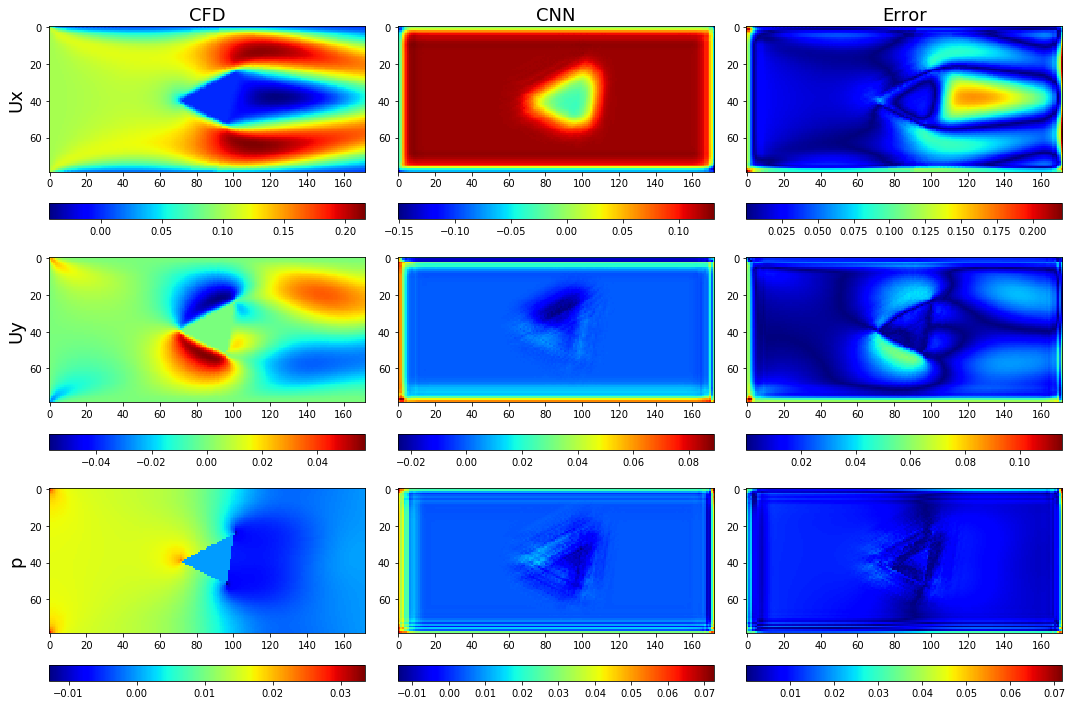

Epoch #11
	Train Loss = 575839.54296875
	Train Total MSE = 44.263041541689915
	Train Ux MSE = 35.41851915631975
	Train Uy MSE = 6.462436448960077
	Train p MSE = 2.3820868730545044
	Validation Loss = 242361.36364746094
	Validation Total MSE = 43.56200078944434
	Validation Ux MSE = 34.92864421329696
	Validation Uy MSE = 6.362637171695802
	Validation p MSE = 2.2707199365622444
Model saved!
Epoch #12
	Train Loss = 552149.443359375
	Train Total MSE = 42.68783387683687
	Train Ux MSE = 34.24745786757696
	Train Uy MSE = 6.1650897434779575
	Train p MSE = 2.275286067099798
	Validation Loss = 232131.08923339844
	Validation Total MSE = 41.84172314178572
	Validation Ux MSE = 33.59571489908291
	Validation Uy MSE = 6.06496685516463
	Validation p MSE = 2.181042015758765
Model saved!
Epoch #13
	Train Loss = 527891.33203125
	Train Total MSE = 40.966858818417506
	Train Ux MSE = 32.92637516203381
	Train Uy MSE = 5.859525498889742
	Train p MSE = 2.1809572832924977
	Validation Loss = 221760.7196044922
	Vali

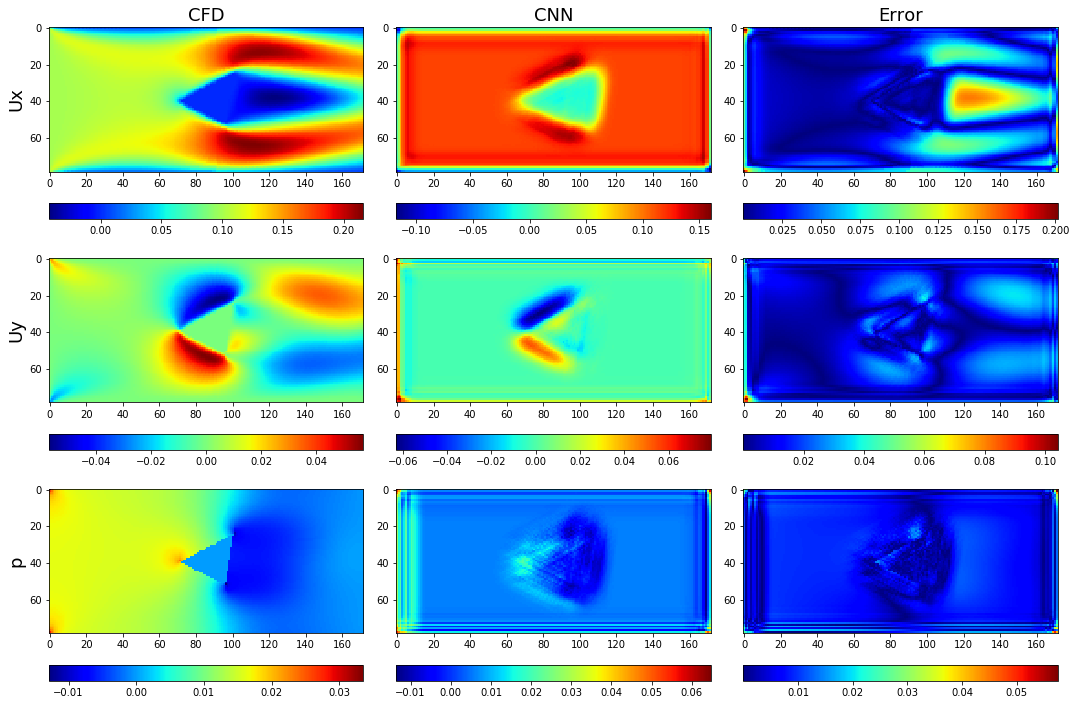

Epoch #21
	Train Loss = 368685.9814453125
	Train Total MSE = 30.655595143636067
	Train Ux MSE = 25.509288152058918
	Train Uy MSE = 3.297160205386934
	Train p MSE = 1.8491463916642326
	Validation Loss = 155990.73797607422
	Validation Total MSE = 30.205684338473944
	Validation Ux MSE = 25.144428325771873
	Validation Uy MSE = 3.260985819938686
	Validation p MSE = 1.8002699458887832
Model saved!
Epoch #22
	Train Loss = 358068.5419921875
	Train Total MSE = 29.806442260742188
	Train Ux MSE = 24.82794797988165
	Train Uy MSE = 3.1419230642772855
	Train p MSE = 1.8365701891127086
	Validation Loss = 153586.65747070312
	Validation Total MSE = 29.521856558776644
	Validation Ux MSE = 24.5293850552252
	Validation Uy MSE = 3.1331837086529055
	Validation p MSE = 1.8592877821113825
Model saved!
Epoch #23


KeyboardInterrupt: 

In [18]:
# Training model
train_model(model, loss_func, train_dataset, test_dataset, optimizer,
           epochs=10000, batch_size=32, device=device, after_epoch=after_epoch,
           m_mse_name="Total MSE",
           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
           m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_ux_name="Ux MSE",
           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
           m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_uy_name="Uy MSE",
           m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
           m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_p_name="p MSE",
           m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
           m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           )